##1. Load dữ liệu

In [25]:
import pandas as pd

file_path = 'data/IMDB-Dataset.csv'
df = pd.read_csv(file_path)

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [26]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


##2. Thực hiện việc xóa các dòng trùng lặp

In [28]:
df.drop_duplicates(inplace=True)

In [30]:
df.describe()

,review,sentiment
count,49582,49582
unique,49582,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


In [31]:
!pip install contractions

##3. Thực hiện tiền xử lý với việc xóa các thẻ HTML, tách các từ viết tắt, đưa từ về dạng gốc và chuẩn hóa về dạng chữ viết thường.

In [32]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

def expand_contractions(text):
  return contractions.fix(text)

stop = set(stopwords.words('english'))

def preprocessing_text(text):
  wl = WordNetLemmatizer()

  soup = BeautifulSoup(text, 'html.parser')
  text = soup.get_text()
  text = expand_contractions(text)

  emoji_clean = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\u2702-\u27B0"           # various symbols
        u"\u24C2-\U0001F251"
        "]+", flags=re.UNICODE)

  text = emoji_clean.sub(r'', text)

  text = re.sub(r'\.(?=\S)', '. ', text)
  text = re.sub(r'http\S+', '', text)

  text = ''.join([word.lower() for word in text if word not in string.punctuation])

  text = ' '.join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()])

  return text

df['review'] = df['review'].apply(preprocessing_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-32-38199b5d62d6>:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [33]:
df

,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter matteis love time money visually stunni...,positive
...,...,...
49995,thought movie right good job creative original...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary school nu...,negative
49998,going disagree previous comment side maltin on...,negative


##4. Thống kê số lượng các nhãn có trong bộ dữ liệu

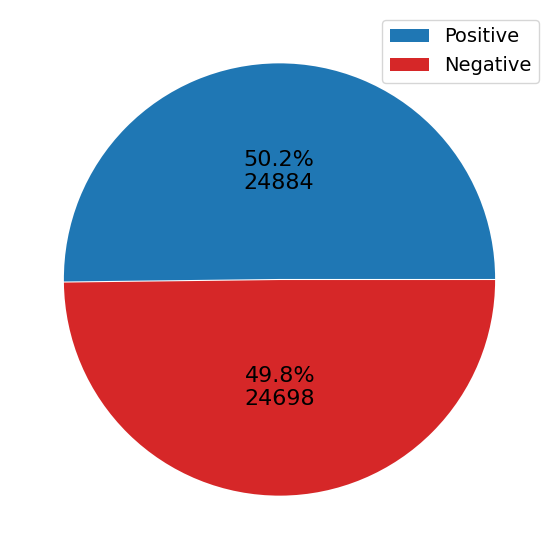

In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def func(pct, allvalues):
  absolute = int(np.round(pct / 100 * np.sum(allvalues)))
  return '{:.1f}%\n{:d}'.format(pct, absolute)

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])
data = [freq_pos, freq_neg]

labels = [r'Positive', r'Negative']

pie, ax = plt.subplots(figsize=(11, 7))
plt.pie(x=data, autopct=lambda pct: func(pct, data), explode=[0.0025]*2, pctdistance=0.5, colors=[sns.color_palette()[0], 'tab:red'], textprops={'fontsize': 16})
plt.legend(labels, loc='best', prop={'size': 14})
pie.savefig('PieChart.png')
plt.show()

##5. Thống kê độ dài mẫu của mỗi class

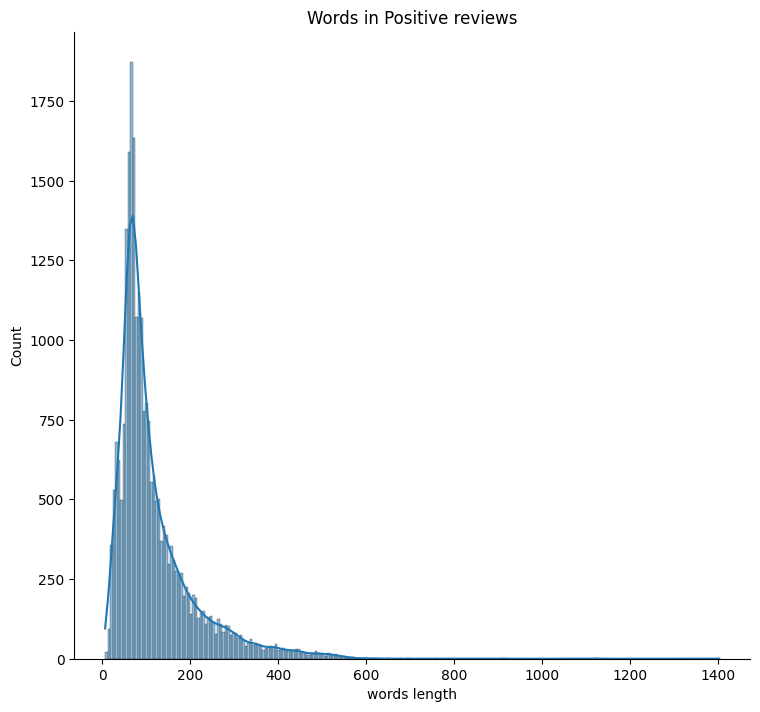

In [37]:
words_len = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words length'] = words_len

hist_pos = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'positive'],
    x='words length', hue='sentiment', kde=True, height=7, aspect=1.1, legend=False
).set(title='Words in Positive reviews')
plt.show(hist_pos)

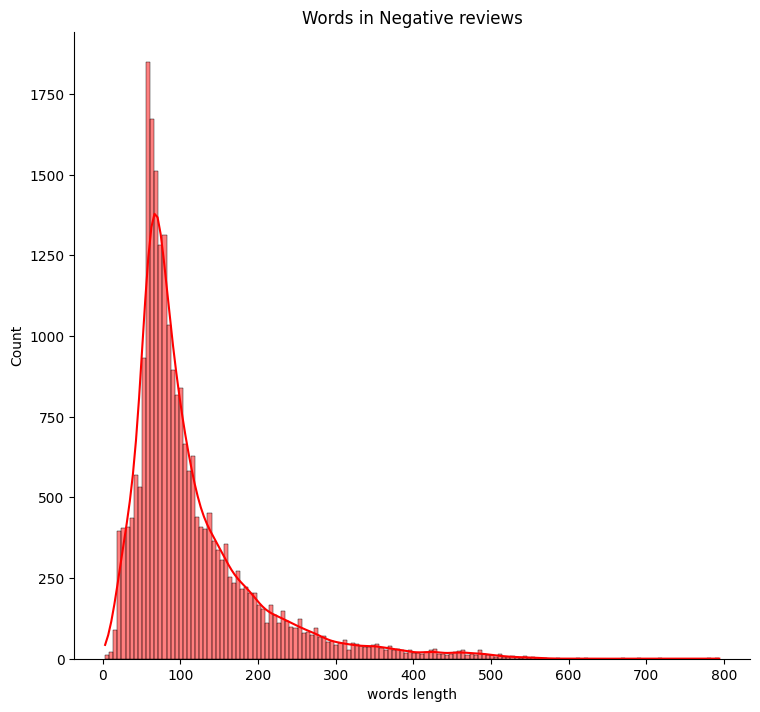

In [40]:
neg_pos = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'negative'],
    x='words length', hue='sentiment', kde=True, height=7, aspect=1.1, legend=False, palette=['red']
).set(title='Words in Negative reviews')
plt.show(neg_pos)

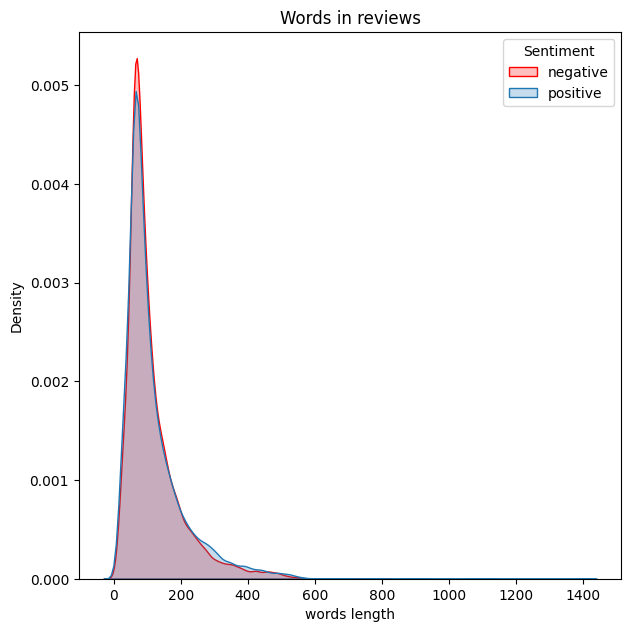

In [41]:
plt.figure(figsize=(7, 7.1))
kernel_distribution = sns.kdeplot(
    data=df_temp, x='words length', hue='sentiment', fill=True, palette=[sns.color_palette()[0], 'red']
).set(title='Words in reviews')
plt.legend(title='Sentiment', labels=['negative', 'positive'])
plt.show(kernel_distribution)

##6. Chia dữ liệu và encode nhãn

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder()
X_data = df['review']
y_data = label_encode.fit_transform(df['sentiment'])

x_train, x_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42
)


##7. Vector hóa dữ tập train

In [43]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train, y_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

##8. Train data với DecisionTree

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
dt_classifier.fit(x_train_encoded, y_train)
y_pred = dt_classifier.predict(x_test_encoded)
accuracy_score(y_test, y_pred)

0.7180598971463145

##9. Train data với RandomForest

In [48]:
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    criterion='entropy',
    random_state=42
)
rf_classifier.fit(x_train_encoded, y_train)
y_pred = rf_classifier.predict(x_test_encoded)
accuracy_score(y_test, y_pred)

0.8416859937481093